In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [22]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=2,padding=1)
        self.conv2 = nn.Conv2d(1, 3, kernel_size=2)
        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm2d(3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x

In [23]:
model=ConvNet2()
##CNN Architecture (batch_size, channels, height, width)

In [5]:
##Obtaining the data : rlon,rlat and GEV parameters
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
gev_params=xr.open_dataset("gev_params_aout.nc")
maxima=xr.open_dataset("aout_maxima_suisse.nc")
maxima

<xarray.Dataset>
Dimensions:        (time: 768, rlon: 176, rlat: 101, week: 6)
Coordinates:
  * time           (time) datetime64[ns] 2003-08-01 ... 2003-09-01T23:00:00
    year           (time) float64 ...
  * rlon           (rlon) float32 -3.0 -2.98 -2.96 -2.94 ... 0.44 0.46 0.48 0.5
  * rlat           (rlat) float32 -1.0 -0.98 -0.96 -0.94 ... 0.94 0.96 0.98 1.0
  * week           (week) int32 31 32 33 34 35 36
    height_2m      float32 ...
    height_10m     float32 ...
Data variables:
    max_pr_weekly  (week, rlat, rlon) float32 ...

In [6]:
##Defining the training set
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/utils"
os.chdir(path)
import training_set

In [53]:
input,output=training_set.training_set_maxim(maxima)

torch.Size([101, 176, 2])
torch.Size([101, 176, 6])


In [54]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

Epoch [5/50], Loss: nan
Epoch [10/50], Loss: nan
Epoch [15/50], Loss: nan
Epoch [20/50], Loss: nan
Epoch [25/50], Loss: nan
Epoch [30/50], Loss: nan
Epoch [35/50], Loss: nan
Epoch [40/50], Loss: nan
Epoch [45/50], Loss: nan
Epoch [50/50], Loss: nan


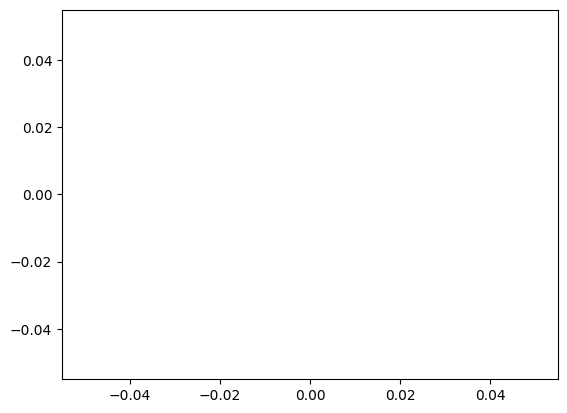

In [55]:
num_epoch=50
batch_size=3

optimizer= torch.optim.Adam(model.parameters(), lr=0.1)
loss_crps=CustomCRPSLoss()
loss_list=[]
for epoch in range(num_epoch):
    #il faut transformer l'input qui est de taille [101,176,2] en [1,2,101,176]
    input_prepared=input.unsqueeze(0)
    input_prepared=input_prepared.permute(0, 3, 1, 2)

    outputs=model(input_prepared)
    #print(outputs.size())
    #print(outputs)
    

    loc, scale, c = outputs[:,0,:,:],outputs[:,1,:,:],outputs[:,2,:,:]
   
    size = (outputs.shape[2]*outputs.shape[3],6)
    #print(size)
    loc=loc.flatten()
    #print(loc.size())
    scale=scale.flatten()
    c=c.flatten()
    loc = loc.unsqueeze(1)
    scale = scale.unsqueeze(1)
    c = c.unsqueeze(1)
    #print('taille loc, scale et c', loc.size(),scale.size(),c.size())
    
    u = torch.rand(size)
    echantillons = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
    #print('size echantillons',echantillons.size())

    true_echant = output.flatten(start_dim=0,end_dim=1)
    #print(true_echant.size())
    
    loss=loss_crps(echantillons,true_echant)
    loss_list.append(torch.detach(loss).numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')

plt.plot(loss_list)
plt.show()
    

In [ ]:
##en input il faut une carte ! pas comme LNN où il faut (lon,lat)
#nous on veut faire du downscaling donc renvoyer une image de meilleure résolution ! 